In [1]:
#%matplotlib inline
%matplotlib widget
import numpy as np
import pandas as pd
import scipy.linalg
import sys,os
import scipy.optimize
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rc
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib

sys.path.append("../")
import TOOLBOX as TLB
import CONSTANTS as CST

formatting=False
if formatting:
    plt.rcParams.update(plt.rcParamsDefault)
    rc('text',usetex=True)
    plt.rcParams.update({'font.size': 14})
    
pd.set_option('display.max_rows', None)

# Numerical Branching Space Evaluation
In this notebook, we investigate the obtention and projections of branching-space vectors numerically, with energy information only.
The so-called numerical branching space and its validity is discussed in the article of [Gonon et al.](https://doi.org/10.1063/1.4991635).
## The Hessian of the Squared Energy Difference
We define the energy difference as:

\begin{equation}
\Delta E = \frac{E_B-E_A}{2}.
\end{equation}
Derivatives of the energy are expressed with (atomic-)mass-weighted displacements ($Q_i$, i running through the number of coordinates), and the gradient and Hessians are

\begin{equation}
\textbf{GD}=
\frac 1 2 \frac{\partial}{\partial \boldsymbol{Q}}\left(E_B-E_A\right)
=
\frac 1 2 \left(\frac{\partial}{\partial \boldsymbol{Q}}E_B-\frac{\partial}{\partial \boldsymbol{Q}}E_A\right)
=
\frac 1 2 \left(\boldsymbol{G}_B-\boldsymbol{G}_A\right),
\end{equation}
and

\begin{equation}
H{\text{D},ij}=\frac 1 2 \frac{\partial^2}{\partial Q_i\partial Q_j}\left(E_B-E_A\right)
=
\frac 1 2 \left(\frac{\partial^2}{\partial Q_i\partial Q_j}E_B
-
\frac{\partial^2}{\partial Q_i\partial Q_j}E_A\right)
=
\frac 1 2 \left(H_{B,ij}-H_{A,ij}\right).
\end{equation}

With such definitions, the Hessian of the squared energy difference reads:

\begin{equation}
H_{\text{SED},ij}=
2\Delta E \frac{\partial^2}{\partial Q_i\partial Q_j}\left(\Delta E\right)
+
2
\left(\frac{\partial}{\partial Q_i}\Delta E\right)
\left(\frac{\partial}{\partial Q_j}\Delta E\right).
\end{equation}

The first term is the energy difference times its Hessian (which is irregular at a conical intersection geometry).
The second term is the [matrix representation of the dyadic product](https://en.wikipedia.org/wiki/Dyadics) of the gradient difference with itself.

At a conical intersection geometry, the Hessian of squared energy difference has two non-zero positive eigenvalues and associated eigenvectors.
These two eigenvectors span the branching plane between the two considered potential energy surfaces.
By construction, they are obtained as an orthonormal pair of modes, the same way as normal modes displacements are obtained from the diagonalization of the a mass-weighted Hessian.

In [2]:
def numericalBranchingSpace(filetag,
                            rootA="A",rootB="B",roottag="AB",check=False,
                            save=False,molecule="Molecule",highest_negative=True):
    """
    Numerical Branching Space tool.
    Inspired from Gonon /et al./, The Journal of Chemical Physics, 2017.

    The program takes as inputs:
    - two fchk files from frequency calculation     {filetag}_{A,B}.fchk or filetag_{rootA,rootB}.fchk 
    and extracts the Hessians and gradients of energy of states A and B to compute the Hessian
    of the squared energy difference.
    At a Conical Intersection locus, the diagonalization of such a Hessian yields two non-zero 
    eigenvalues, associated to the branching space of the CoIn.

    - TODO print the BSV as if there were results of a Gaussian calculation (as in a .log)
    """
    with open(filetag+"_NBS.dat","w") as ResultsFile:
        ResultsFile.write("Numerical Branching Space information for "+filetag+" calculations")
        ResultsFile.write("\n")
        ResultsFile.write("\n")

    if roottag=="num":
        filetagA=filetag+"_"+str(rootA)+".fchk"
        filetagB=filetag+"_"+str(rootB)+".fchk"
    elif roottag=="AB":
        filetagA=filetag+"_A.fchk"
        filetagB=filetag+"_B.fchk"

    NAtoms,NCoords,atomicNumbers,currentCoordinates=TLB.fchk2coordinates(filetagA)
    currentCoordinates=currentCoordinates.flatten() # Angstrom
    currentEnergyS1,currentGradientS1,currentHessianS1,atomicMasses=TLB.fchk2derivatives(filetagA,mw=True,freq=True)[:4]
    currentGradientS1=currentGradientS1.flatten() # Hartree / (sqrt(m_e)a_0)
    currentEnergyS2,currentGradientS2,currentHessianS2=TLB.fchk2derivatives(filetagB,mw=True,freq=True)[:3]
    currentGradientS2=currentGradientS2.flatten() # Hartree / (sqrt(m_e)a_0)
    
    #############################
    currentEnergyDifference=0.5*(currentEnergyS2-currentEnergyS1)
    currentGradientDifference=0.5*(currentGradientS2-currentGradientS1)
    currentHessianDifference=0.5*(currentHessianS2-currentHessianS1)
    
    currentGradientDifferenceProjector=np.tensordot(currentGradientDifference,currentGradientDifference,axes=0)
    currentSquaredHessianDifference=2*(currentEnergyDifference)*(currentHessianDifference)+2*currentGradientDifferenceProjector
    eigval,diagonalizer=scipy.linalg.eigh(currentSquaredHessianDifference)
    #############################
    with open(filetag+"_NBS.dat","a+") as ResultsFile:
        ResultsFile.write("Eigenvalues of the Hessian of the squared energy difference:")
        ResultsFile.write("\n")
        ResultsFile.write("\n")
        for i in range(len(eigval)):
            ResultsFile.write(str(i+1)+"\t"+str(eigval[i]))
            ResultsFile.write("\n")
        ResultsFile.write("\n")
    eigvec=diagonalizer.T
    currentHighestNegative=eigvec[0].flatten()
    currentBranchingSpaceVector1=eigvec[-1].flatten()
    currentBranchingSpaceVector2=eigvec[-2].flatten()

    current_coordinates=currentCoordinates.reshape(NAtoms,3)
    current_HighestNegative=currentHighestNegative.reshape(NAtoms,3) 
    current_BranchingSpaceVector1=currentBranchingSpaceVector1.reshape(NAtoms,3) 
    current_BranchingSpaceVector2=currentBranchingSpaceVector2.reshape(NAtoms,3) 

    with open(filetag+"_NBS.dat","a+") as ResultsFile:
        ResultsFile.write("Length (E_h^2/(a_0^2·m_e)) and components of the Unitary BS vector associated to the highest non-zero eigenvalue:")
        ResultsFile.write("\n")
        ResultsFile.write("\n")
        ResultsFile.write("\t"+str(eigval[-1]))
        ResultsFile.write("\n")
        ResultsFile.write("\n")
        to_print=pd.DataFrame(currentBranchingSpaceVector1.reshape(NAtoms,3),index=range(1,NAtoms+1))
        to_print.columns=['comp. x','comp. y','comp. z']
        ResultsFile.write(to_print.to_string())
        ResultsFile.write("\n")
        ResultsFile.write("\n")
        ResultsFile.write("Length (E_h^2/(a_0^2·m_e)) and components of the Unitary BS vector associated to the lowest non-zero eigenvalue:")
        ResultsFile.write("\n")
        ResultsFile.write("\n")
        ResultsFile.write("\t"+str(eigval[-2]))
        ResultsFile.write("\n")
        ResultsFile.write("\n")
        to_print=pd.DataFrame(currentBranchingSpaceVector1.reshape(NAtoms,3),index=range(1,NAtoms+1))
        to_print.columns=['comp. x','comp. y','comp. z']
        ResultsFile.write(to_print.to_string())
        ResultsFile.write("\n")

    if check:
        fig,ax=TLB.visualizeDisplacementNospec(currentCoordinates,currentBranchingSpaceVector1,atomicNumbers=atomicNumbers)
        ax.set_title("NBS 1 with length "+str(eigval[-1]))
        if save:
            plt.savefig(filetag+"_NBS1.png")
            plt.savefig(filetag+"_NBS1.pdf")
        plt.show()
        fig,ax=TLB.visualizeDisplacementNospec(currentCoordinates,currentBranchingSpaceVector2,atomicNumbers=atomicNumbers)
        ax.set_title("NBS 2 with length "+str(eigval[-2]))
        if save:
            plt.savefig(filetag+"_NBS2.png")
            plt.savefig(filetag+"_NBS2.pdf")
        plt.show()
        if highest_negative:
            fig,ax=TLB.visualizeDisplacementNospec(currentCoordinates,currentHighestNegative,atomicNumbers=atomicNumbers)
            ax.set_title("NBS -1 with length "+str(eigval[0]))
            plt.show()
    return eigval[-2:][::-1],eigvec[-2:][::-1]

## Example (with symmetry)
Let us look at the use of the numerical branching space for conical intersections in the excited states of PPE molecules.
For instance with symmetrically meta-substituted PPE m22, we have found a conical intersection between the first two excited states, involving local excitations on the left or the right of the molecule.

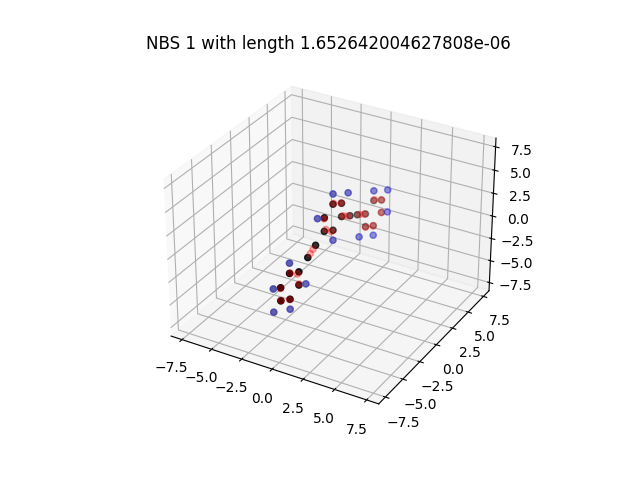

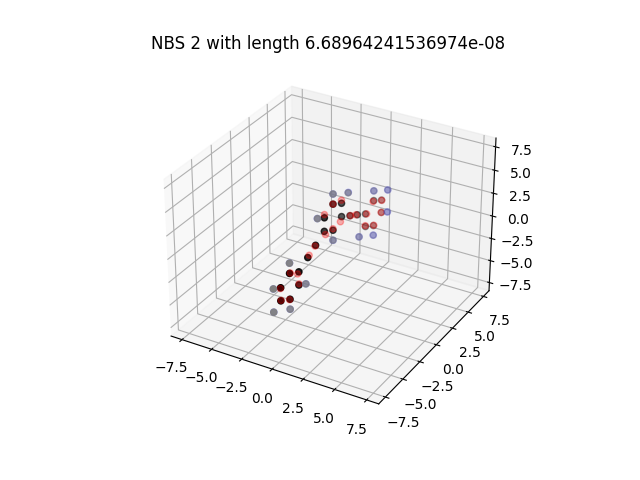

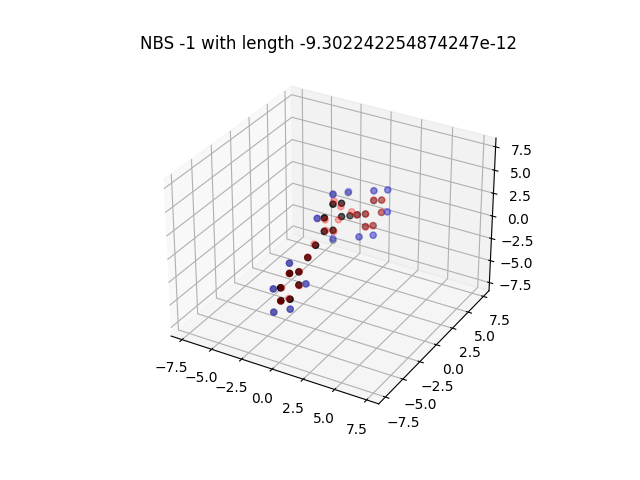

In [3]:
filetag="m22_CoIn_HARVEY_NBS_s22_sym"
#filetag="m23_CoIn_SICILIA_NBS_s41_sym"
NAtoms,NCoords,atomicNumbers,coordinates=TLB.fchk2coordinates(filetag+"_1.fchk")
atomicMasses=TLB.fchk2derivatives(filetag+"_1.fchk")[3]
BSVLengths,BSVVectors=numericalBranchingSpace(filetag,
                        rootA="1",rootB="2",roottag="num",check=True,
                        save=True,molecule="Molecule",highest_negative=True)

We find two non-zero positive eigenvalues and associated eigenvectors ($\boldsymbol{u}_1$ and $\boldsymbol{u}_2$) are plotted as displacements (without any transformation...) from the coordinates of the CoIn.
We check that the "highest negative" eigenvalue is small and negligible compared to the two non-zero positive eigenvalues (measure of the validity of the numerical evaluation at this geometry).

Now, let us manipulate the branching-space lengths and branching-space vectors and check if
\begin{equation}
\begin{aligned}
\boldsymbol{u}_1\cdot\boldsymbol{u}_1&=1\\
\boldsymbol{u}_2\cdot\boldsymbol{u}_2&=1\\
\boldsymbol{u}_1\cdot\boldsymbol{u}_2&=0
\end{aligned}
\end{equation}

In [4]:
print("NAtoms, NCoords: {}, {}".format(NAtoms,NCoords))
print("Branching-space vectors shape: ",BSVVectors.shape)
print("Associated Lengths: ",BSVLengths)

NAtoms, NCoords: 36, 108
Branching-space vectors shape:  (2, 108)
Associated Lengths:  [1.65264200e-06 6.68964242e-08]


In [5]:
print("u1·u1 = {}".format(np.dot(BSVVectors[0],BSVVectors[0]))) # normalized 
print("u2·u2 = {}".format(np.dot(BSVVectors[1],BSVVectors[1]))) # normalized 
print("u1·u2 = {}".format(np.dot(BSVVectors[0],BSVVectors[1]))) # and orthogonal

u1·u1 = 0.9999999999999994
u2·u2 = 1.0000000000000002
u1·u2 = -1.6597483537777642e-17


The branching-space vectors are, for now, orthogonal and normalized, and their associated "lengths" (eigenvalues) are in mass-weighted atomic units.

The Hessian of squared energy difference is diagonalized when expressed in the system of mass-weighted cartesian coordinates.
The "normal" branching space vectors are thus obtained in this system of coordinates  and orthogonal only in this case.
To obtain the displacements associated to the branching-space vectors in the real space of cartesian coordinates, we "de-"mass-weight each coordinates
\begin{equation}
\boldsymbol{u}_{\text{cart},i}=\boldsymbol{M}^{-\frac{1}{2}}\cdot \boldsymbol{u}_i
\end{equation}
The resulting vectors can be normalized again, calculating the normalization factor:
\begin{equation}
N_i=\sqrt{\left(\sum_k^{3N}u_{\text{cart},i,k}^2\right)^{-1}}=\sqrt{\eta_i}
\end{equation}
where $\eta_i$ is a reduced mass associated to the branching-space vector $i$.
_(inspired from [Ochtersky, Gaussian White Paper](https://gaussian.com/wp-content/uploads/dl/vib.pdf) for vibrational analysis)_

In [6]:
print(atomicMasses)
# Inspired from Ochtersky White Paper "Vibrational Analysis in Gaussian"...
inverseSquareRootMasses=np.diag(1/np.sqrt(atomicMasses.flatten()*CST.AMU_TO_ME)) 
BSVVectorsCart=np.dot(inverseSquareRootMasses,BSVVectors.T) # vectors(mw coords) --> vectors(cart coords)
print(BSVVectorsCart)
normalizationFactors=np.sqrt(1/np.sum(BSVVectorsCart**2,axis=0)) # sqrt(m_e)
BSVReducedMasses=1/np.sum(BSVVectorsCart**2,axis=0)/CST.AMU_TO_ME # m_e --> AMU
print("Normalization Factor (a.u.):\n",normalizationFactors)
print("reducedMasses (AMU):\n",BSVReducedMasses)
BSVVectorsCart=normalizationFactors*BSVVectorsCart # not normalized --> normalized 
BSVVectorsCart=BSVVectorsCart.T
print("ucart1·ucart1 = {}".format(np.dot(BSVVectorsCart[0],BSVVectorsCart[0]))) # normalized
print("ucart2·ucart2 = {}".format(np.dot(BSVVectorsCart[1],BSVVectorsCart[1]))) # normalized
print("ucart1·ucart2 = {}".format(np.dot(BSVVectorsCart[0],BSVVectorsCart[1]))) # but not rigorously orthogonal

[12.         12.         12.         12.         12.         12.
 12.         12.         12.         12.         12.         12.
 12.         12.         12.         12.         12.         12.
 12.         12.         12.         12.         12.         12.
 12.         12.         12.         12.         12.         12.
 12.         12.         12.         12.         12.         12.
 12.         12.         12.         12.         12.         12.
 12.         12.         12.         12.         12.         12.
 12.         12.         12.         12.         12.         12.
 12.         12.         12.         12.         12.         12.
 12.         12.         12.         12.         12.         12.
  1.00782504  1.00782504  1.00782504  1.00782504  1.00782504  1.00782504
  1.00782504  1.00782504  1.00782504  1.00782504  1.00782504  1.00782504
  1.00782504  1.00782504  1.00782504  1.00782504  1.00782504  1.00782504
  1.00782504  1.00782504  1.00782504  1.00782504  1.00782504  1.00

### Projection of the Branching Space Vectors

The "normal" branching-space vectors must be "length-weighted" before they are projected onto another orthonormal basis. 
This way, we retrieve gradient-like vectors (comparable to derivative coupling and gradient difference vectors) from the branching-space directions.
Now, let us "weight" the branching-space vectors with their respective eigenvalue (length, $l_i$)
\begin{equation}
\boldsymbol{x}_i=\sqrt{\frac{l_i}{2}}\boldsymbol{u}_i
\end{equation}

In [7]:
BranchingSpaceVector1=np.sqrt(BSVLengths[0]/2)*BSVVectors[0] # E_h/(a_0·sqrt(m_e))
BranchingSpaceVector2=np.sqrt(BSVLengths[1]/2)*BSVVectors[1] # E_h/(a_0·sqrt(m_e))
print("x1·x1 = {}".format(np.dot(BranchingSpaceVector1,BranchingSpaceVector1))) # not normalized
print("x2·x2 = {}".format(np.dot(BranchingSpaceVector2,BranchingSpaceVector2))) # not normalized 
print("x1·x2 = {}".format(np.dot(BranchingSpaceVector1,BranchingSpaceVector2))) # and orthogonal

x1·x1 = 8.263210023139036e-07
x2·x2 = 3.3448212076848716e-08
x1·x2 = -3.650691047181331e-24


Let us find how the length-weighted branching-space vectors are expressed in a basis of orthonormal displacements vectors.
For instance, a basis of interest is the basis of the normal modes (translations, rotations and vibrations) found at the equilibrium geometry of the molecule.
In the same way, we have to sets of modes:
- cartesian normal modes displacements, $\boldsymbol{L}_{\text{cart},i}$ (normalized but non orthogonal) ($\texttt{printedModesCart}$)
- mass-weighted normal modes displacements $\boldsymbol{L}_{i}$ (normalized and orthogonal) ($\texttt{normalModes}$)

In the following, we show the frequencies and reduced masses associated to the normal modes of the molecule at its equilibrium geometry in the electronic ground state.

In [8]:
#filetag="m22_opt-freq_S0.fchk"
filetag="m22_opt-freq_S0.fchk"
frequencies,reducedMasses,printedModesCart,atomicNumbers,atomicMasses,coordinates_fcp=TLB.fchk2vibrationalAnalysis(filetag,gaussianType=True)
df_vib=pd.DataFrame({"Freq (rcm)":frequencies,"Freq (a.u.)":(frequencies/CST.HARTREE_TO_RCM)**2,"μ (AMU)":reducedMasses,"μ (m_e)":reducedMasses*CST.AMU_TO_ME})
df_vib.index=np.append(["TR"]*6,range(1,len(coordinates_fcp)+1-6))
df_vib

(108,)
(108, 6)
(108, 102)
(108, 6)
(108, 108)


,Freq (rcm),Freq (a.u.),μ (AMU),μ (m_e)
TR,-2.624465,1.429922e-10,5.366196,9781.977429
TR,-1.065568,2.357182e-11,6.725276,12259.427745
TR,-0.942681,1.844847e-11,6.516836,11879.465822
TR,-0.023500,1.146452e-14,7.725122,14082.036794
TR,0.008302,1.430785e-15,7.725318,14082.392983
TR,0.036276,2.731941e-14,7.725269,14082.304446
1,11.636590,2.811139e-09,3.654091,6661.000015
2,13.174665,3.603380e-09,3.886694,7085.009310
3,18.649897,7.220774e-09,5.836878,10639.977125
4,48.289466,4.841007e-08,4.775342,8704.916615


The cartesian normal modes displacements can be further transformed to mass-weighted normal modes displacements, and we can check they form and orthonormal basis looking at the Gram matrix of overlaps

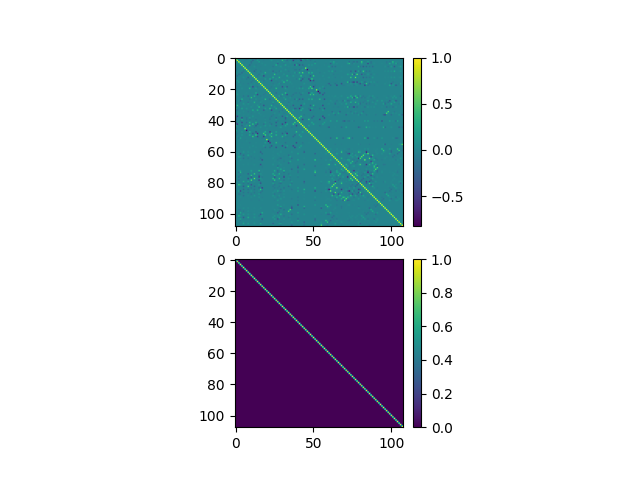

In [9]:
normalModes=TLB.orthogonalizeNormalModes(printedModesCart,reducedMasses,atomicMasses,check=True)

The length-weighted branching-space vectors $\boldsymbol{x}_i$ are still expressed in the mass-weighted coordinates system, and can be projected onto the basis elements $\boldsymbol{L}_k$

In [10]:
BranchingSpaceVector1_InNM=np.dot(normalModes,BranchingSpaceVector1)
PercentagesNM_InBSV1=(BranchingSpaceVector1_InNM/np.sqrt(BSVLengths[0]/2))**2
print("Sum of the percentages of NMS0 in BSV1",np.sum(PercentagesNM_InBSV1))
BranchingSpaceVector2_InNM=np.dot(normalModes,BranchingSpaceVector2)
PercentagesNM_InBSV2=(BranchingSpaceVector2_InNM/np.sqrt(BSVLengths[1]/2))**2
print("Sum of the percentages of NMS0 in BSV2",np.sum(PercentagesNM_InBSV2))
# Should be equal
# print(np.sqrt(np.sum(BranchingSpaceVector1_InNM**2)))
# print(np.sqrt(BSVLengths[0]/2))
# are equal
df=pd.DataFrame({"BSV1 (NMS0)":BranchingSpaceVector1_InNM,
                 "%NMS0 in BSV1":100*np.round(PercentagesNM_InBSV1,3),
                 "BSV2 (NMS0)":BranchingSpaceVector2_InNM,
                 "%NMS0 in BSV2":100*np.round(PercentagesNM_InBSV2,3)})
df.index=np.append(["TR"]*6,range(1,len(coordinates)+1-6))
df

Sum of the percentages of NMS0 in BSV1 0.9999999999999997
Sum of the percentages of NMS0 in BSV2 1.0000000000000009


,BSV1 (NMS0),%NMS0 in BSV1,BSV2 (NMS0),%NMS0 in BSV2
TR,-3.440930e-07,0.0,1.076148e-10,0.0
TR,-2.950824e-08,0.0,1.030370e-11,0.0
TR,-2.385181e-07,0.0,-2.241134e-12,0.0
TR,-1.228356e-10,0.0,-1.973434e-13,0.0
TR,2.088564e-11,0.0,-2.855652e-15,0.0
TR,-1.084693e-10,0.0,-1.012481e-13,0.0
1,2.654894e-07,0.0,-6.351714e-11,0.0
2,4.081697e-07,0.0,-6.486642e-11,0.0
3,6.454233e-09,0.0,6.958621e-07,0.0
4,-2.186607e-07,0.0,1.486374e-10,0.0
